# The Fire Net Model

This is my own model using normal convolutions and we will also design one combining this model and depth wise separable convolutions as used in Mobile Net.

Therefore, for my project we have:
* A bench mark model which is a pre trained Mobile net.
* A fire net model made up of standard convolution.
* A fire net model made up of depthwise convolution.
* A model from PyImage Search.

In [1]:
import tensorflow as tf
import numpy as np
import os
import numpy as np 
import matplotlib.pyplot as plt
import glob
import shutil
import tensorflow_hub as hub

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from sklearn.metrics import classification_report, confusion_matrix,roc_curve,auc, roc_auc_score,precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay,RocCurveDisplay,ConfusionMatrixDisplay


In [3]:
_URL = 'https://fire-net-datasets.s3.amazonaws.com/Training_Dataset.zip'

zip_file = tf.keras.utils.get_file(origin=_URL,extract=True)  
#This will ge the file and extract it to a directory and extract to /Training Dataset

2006548480/2006536205 [==============================] - 121s 0us/step


In [4]:
print(os.path.dirname(zip_file))
#This function returns the directory of the extracted folder without the extracted folder inclusive

/root/.keras/datasets


In [5]:
base_dir = os.path.join(os.path.dirname(zip_file), 'Training Dataset')
#A good way to add the directory of the extracted folder and also the extracted folder itself.
print(base_dir)

/root/.keras/datasets/Training Dataset


In [6]:
classes = ['Fire', 'NoFire']

In [7]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.7)], images[round(len(images)*0.7):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

Fire: 3622 Images
NoFire: 4125 Images


In [8]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [9]:
batch_size = 100
IMG_SHAPE = 128

In [10]:
image_gen_train = ImageDataGenerator(rescale = 1./255,
                    zoom_range = 0.5,
                    rotation_range=45,
                    horizontal_flip=True,
                    width_shift_range=0.15,
                    height_shift_range=0.15,
                    shear_range=0.2)
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                            directory=train_dir,
                                            shuffle=True,
                                            target_size=(IMG_SHAPE,IMG_SHAPE),
                                            class_mode='binary')
print(train_data_gen.samples)
print(train_data_gen.n)
train_data_num = train_data_gen.samples
#Find our size of datasets. each

Found 5423 images belonging to 2 classes.
5423
5423


In [11]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

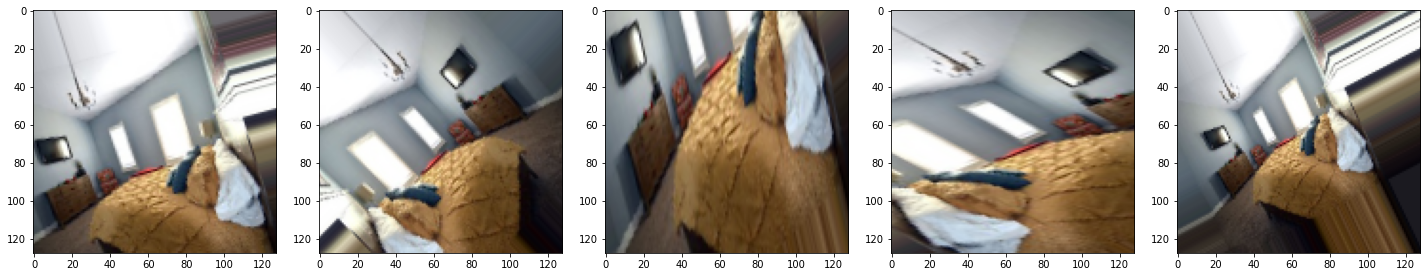

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [13]:
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                            directory=val_dir,
                            target_size=(IMG_SHAPE,IMG_SHAPE),
                            class_mode='binary',
                            shuffle = False)

Found 2324 images belonging to 2 classes.


In [14]:
print(val_data_gen.samples)
print(val_data_gen.n)
val_data_num = val_data_gen.samples

2324
2324


In [15]:
model = Sequential()
model.add(Conv2D(16, 3, padding = "same", input_shape = (IMG_SHAPE, IMG_SHAPE, 3)))
model.add(MaxPooling2D(2,2))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv2D(32, 3, padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Conv2D(64, 3, padding = 'same'))
model.add(MaxPooling2D(2,2))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation = 'relu'))

model.add(Dense(2, activation = 'softmax'))

### Places to test
1. Overfit first so that you see maximum number of epoch. (Overfits above 60)
2. After overfitting, find the epoch where you want to reduce the learning rate. (This is 60 epoch)
3. Test with discarding dropout and use batch normalization. (Performance Accuracy) **Test this
4. Add a Dense layer of 128. (Accuracy) //No need, parameters already high.
5. MaxPooling to default stride (Accuracy) //Will increase computation.
6. After finding best epoch, use reduce early and stop. (Generalization)// No need, found the optimum range at about 60 epoch.
7. Convert to depthwise separable convolution and increase layers.

In [16]:
model.summary()

#Mobile Net had 2 million parameters

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 activation (Activation)     (None, 64, 64, 16)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                    

In [17]:
EPOCHS = 100
model.compile(optimizer="adam",
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])

history = model.fit(train_data_gen,epochs= EPOCHS,
                steps_per_epoch = int(np.ceil(train_data_gen.n / float(batch_size))),
                validation_data = val_data_gen,
                validation_steps = int(np.ceil(val_data_gen.n / float(batch_size))))

Epoch 1/100
55/55 [==============================] - 118s 2s/step - loss: 0.8367 - accuracy: 0.5550 - val_loss: 0.6881 - val_accuracy: 0.5525
Epoch 2/100
55/55 [==============================] - 108s 2s/step - loss: 0.6119 - accuracy: 0.6736 - val_loss: 0.5903 - val_accuracy: 0.7608
Epoch 3/100
55/55 [==============================] - 109s 2s/step - loss: 0.5270 - accuracy: 0.7483 - val_loss: 0.5802 - val_accuracy: 0.7642
Epoch 4/100
55/55 [==============================] - 109s 2s/step - loss: 0.4870 - accuracy: 0.7817 - val_loss: 0.5419 - val_accuracy: 0.8016
Epoch 5/100
55/55 [==============================] - 108s 2s/step - loss: 0.4664 - accuracy: 0.7894 - val_loss: 0.4985 - val_accuracy: 0.8046
Epoch 6/100
55/55 [==============================] - 108s 2s/step - loss: 0.4715 - accuracy: 0.7890 - val_loss: 0.5212 - val_accuracy: 0.7904
Epoch 7/100
55/55 [==============================] - 107s 2s/step - loss: 0.4401 - accuracy: 0.8027 - val_loss: 0.5045 - val_accuracy: 0.7728
Epoch 

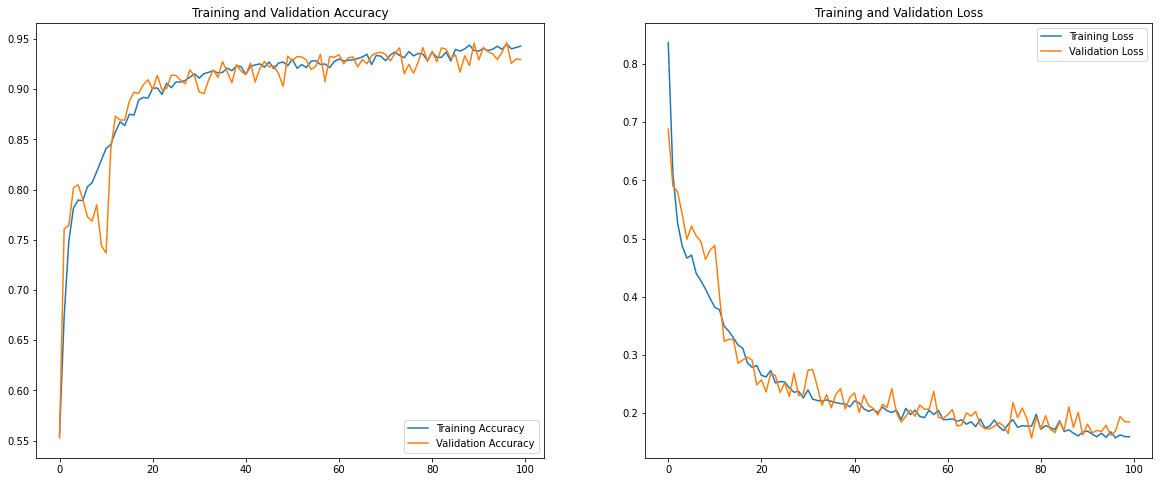

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [22]:
#Confusion Matrix and Classification Report
val_data_gen.reset()
Y_pred = model.predict(val_data_gen, int(np.ceil(val_data_gen.n / float(batch_size))))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_data_gen.classes, y_pred))
print('Classification Report')
target_names = ['Fire', 'No Fire']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 966  121]
 [  43 1194]]
Classification Report
              precision    recall  f1-score   support

        Fire       0.96      0.89      0.92      1087
     No Fire       0.91      0.97      0.94      1237

    accuracy                           0.93      2324
   macro avg       0.93      0.93      0.93      2324
weighted avg       0.93      0.93      0.93      2324



In [23]:
#Confusion Matrix and Classification Report

#Something is Wrong
val_data_gen.reset()
Y_pred = model.predict(val_data_gen, int(np.ceil(val_data_gen.n / float(batch_size))))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_data_gen.classes, y_pred))
print('Classification Report')
target_names = ['Fire', 'No Fire']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 966  121]
 [  43 1194]]
Classification Report
              precision    recall  f1-score   support

        Fire       0.96      0.89      0.92      1087
     No Fire       0.91      0.97      0.94      1237

    accuracy                           0.93      2324
   macro avg       0.93      0.93      0.93      2324
weighted avg       0.93      0.93      0.93      2324



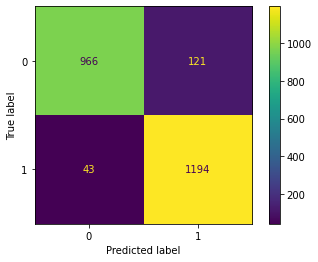

In [24]:
cm = confusion_matrix(val_data_gen.classes, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

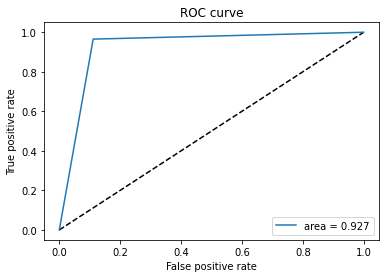

In [25]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(val_data_gen.classes, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

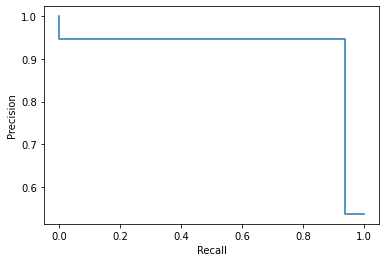

In [ ]:
prec, recall, _ = precision_recall_curve(val_data_gen.classes, y_pred)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [26]:
model_name = "firenet"
model_fullname = "{}_epochs_{}".format(model_name,EPOCHS)

In [27]:
export_path_keras = "./{}.h5".format(model_fullname)
print(export_path_keras)

model.save(export_path_keras)

./firenet_epochs_100.h5


In [28]:
export_path_sm = "./{}".format(model_fullname)
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./firenet_epochs_100
INFO:tensorflow:Assets written to: ./firenet_epochs_100/assets


In [29]:
!ls {export_path_sm}

assets	saved_model.pb	variables


In [30]:
!zip -r {model_fullname}.zip {export_path_sm}

  adding: firenet_epochs_100/ (stored 0%)
  adding: firenet_epochs_100/variables/ (stored 0%)
  adding: firenet_epochs_100/variables/variables.index (deflated 67%)
  adding: firenet_epochs_100/variables/variables.data-00000-of-00001 (deflated 23%)
  adding: firenet_epochs_100/saved_model.pb (deflated 89%)
  adding: firenet_epochs_100/assets/ (stored 0%)


In [31]:
reloaded = tf.keras.models.load_model(
  export_path_keras, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 activation (Activation)     (None, 64, 64, 16)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                    

In [32]:
EPOCHS = 20
history = reloaded.fit(train_data_gen,epochs= EPOCHS,
                steps_per_epoch = int(np.ceil(train_data_gen.n / float(batch_size))),
                validation_data = val_data_gen,
                validation_steps = int(np.ceil(val_data_gen.n / float(batch_size))))

Epoch 1/20
55/55 [==============================] - 112s 2s/step - loss: 0.1606 - accuracy: 0.9417 - val_loss: 0.1787 - val_accuracy: 0.9324
Epoch 2/20
55/55 [==============================] - 107s 2s/step - loss: 0.1596 - accuracy: 0.9393 - val_loss: 0.2025 - val_accuracy: 0.9273
Epoch 3/20
55/55 [==============================] - 110s 2s/step - loss: 0.1611 - accuracy: 0.9425 - val_loss: 0.1691 - val_accuracy: 0.9367
Epoch 4/20
55/55 [==============================] - 106s 2s/step - loss: 0.1449 - accuracy: 0.9439 - val_loss: 0.1573 - val_accuracy: 0.9410
Epoch 5/20
55/55 [==============================] - 106s 2s/step - loss: 0.1612 - accuracy: 0.9419 - val_loss: 0.1523 - val_accuracy: 0.9449
Epoch 6/20
55/55 [==============================] - 106s 2s/step - loss: 0.1554 - accuracy: 0.9406 - val_loss: 0.1804 - val_accuracy: 0.9320
Epoch 7/20
55/55 [==============================] - 105s 2s/step - loss: 0.1484 - accuracy: 0.9441 - val_loss: 0.1689 - val_accuracy: 0.9432
Epoch 8/20
55

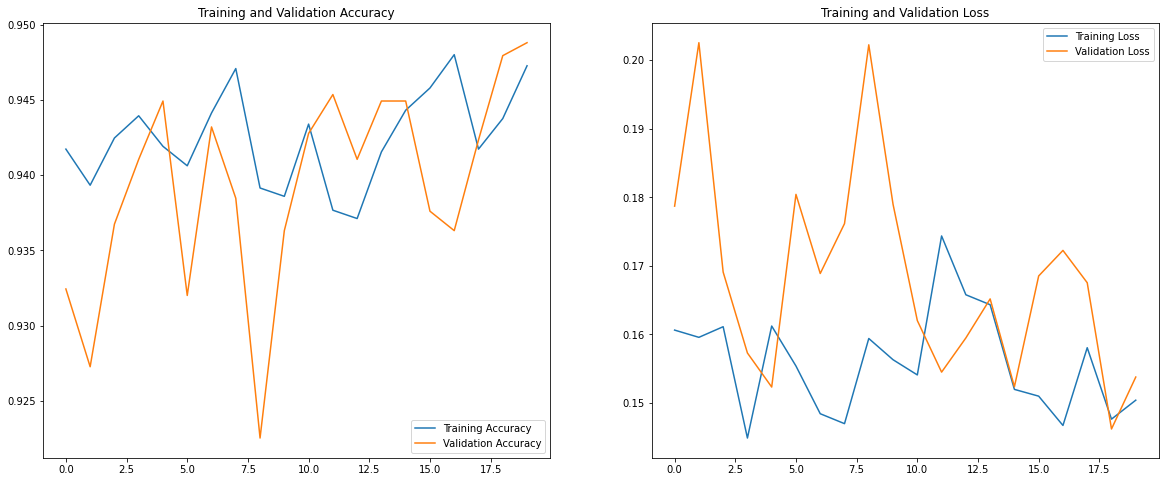

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [34]:
#Confusion Matrix and Classification Report

#Something is Wrong
val_data_gen.reset()
Y_pred = model.predict(val_data_gen, int(np.ceil(val_data_gen.n / float(batch_size))))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_data_gen.classes, y_pred))
print('Classification Report')
target_names = ['Fire', 'No Fire']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 966  121]
 [  43 1194]]
Classification Report
              precision    recall  f1-score   support

        Fire       0.96      0.89      0.92      1087
     No Fire       0.91      0.97      0.94      1237

    accuracy                           0.93      2324
   macro avg       0.93      0.93      0.93      2324
weighted avg       0.93      0.93      0.93      2324



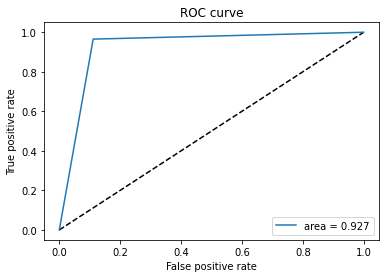

In [35]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(val_data_gen.classes, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

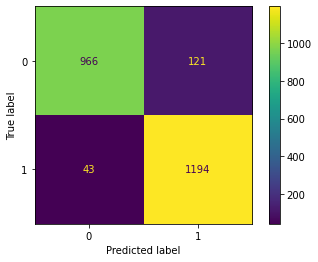

In [36]:
cm = confusion_matrix(val_data_gen.classes, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

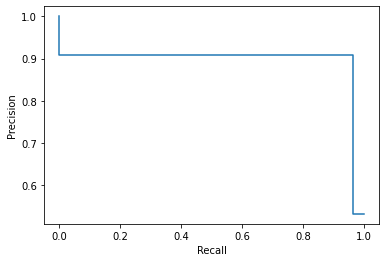

In [37]:
prec, recall, _ = precision_recall_curve(val_data_gen.classes, y_pred)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()